# Task 1

### Data Preprocessing
* Remove records containing missing (NA) values
* Encode categorical attributes such as Country and Status
* Normalize all numerical features

In [2]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler


def load_and_clean(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()
    df = df.dropna()
    return df


def encode_categorical(df: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    df = df.copy()
    encoder = OrdinalEncoder()
    df[columns] = encoder.fit_transform(df[columns])
    return df


def normalize_numerical(df: pd.DataFrame, exclude: list[str]) -> pd.DataFrame:
    df = df.copy()
    numerical_columns = df.columns.difference(exclude)
    scaler = MinMaxScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    return df


CATEGORICAL_COLUMNS = ["Country", "Status"]
TARGET_COLUMN = "Life expectancy"

raw_df = load_and_clean("Life Expectancy Data.csv")
encoded_df = encode_categorical(raw_df, CATEGORICAL_COLUMNS)
normalized_df = normalize_numerical(encoded_df, exclude=CATEGORICAL_COLUMNS)

print(f"Rows before cleaning: {len(pd.read_csv('Life Expectancy Data.csv'))}")
print(f"Rows after cleaning:  {len(normalized_df)}")
normalized_df.head()

Rows before cleaning: 2938
Rows after cleaning:  1649


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,0.0,1.000000,1.0,0.466667,0.362881,0.038750,0.0,0.003759,0.649485,0.008780,...,0.031250,0.543590,0.649485,0.0,0.004889,0.026074,0.630996,0.612100,0.511752,0.357576
1,0.0,0.933333,1.0,0.353333,0.373961,0.040000,0.0,0.003878,0.618557,0.003743,...,0.572917,0.545055,0.618557,0.0,0.005127,0.000253,0.642066,0.619217,0.508547,0.351515
2,0.0,0.866667,1.0,0.353333,0.369806,0.041250,0.0,0.003861,0.639175,0.003271,...,0.614583,0.541392,0.639175,0.0,0.005287,0.024525,0.649446,0.626335,0.502137,0.345455
3,0.0,0.800000,1.0,0.344444,0.375346,0.043125,0.0,0.004123,0.670103,0.021203,...,0.666667,0.569963,0.670103,0.0,0.005608,0.002857,0.656827,0.637011,0.494658,0.339394
4,0.0,0.733333,1.0,0.337778,0.379501,0.044375,0.0,0.000374,0.680412,0.022923,...,0.677083,0.522344,0.680412,0.0,0.000519,0.002302,0.667897,0.644128,0.485043,0.321212


### Exploratory Data Analysis
Present descriptive statistics and visualizations for the following attributes:
* GDP
* BMI
* Alcohol
* Total Expenditure

In [ ]:
import matplotlib.pyplot as plt

EDA_COLUMNS = ["GDP", "BMI", "Alcohol", "Total expenditure"]

raw_df[EDA_COLUMNS].describe()

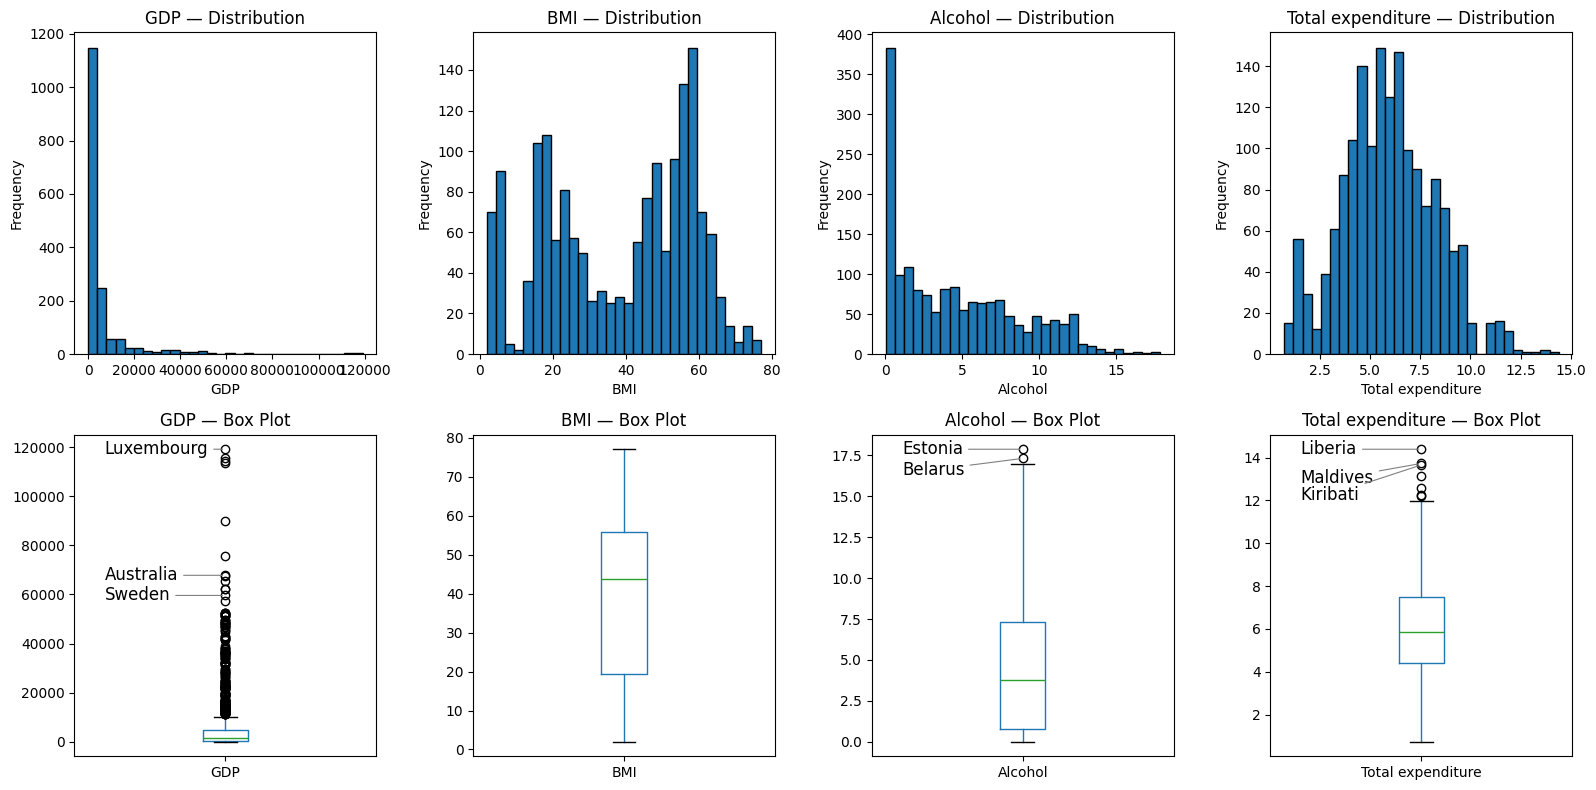

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, col in enumerate(EDA_COLUMNS):
    raw_df[col].hist(bins=30, ax=axes[0, i], edgecolor="black")
    axes[0, i].set_title(f"{col} — Distribution")
    axes[0, i].set_xlabel(col)
    axes[0, i].set_ylabel("Frequency")
    axes[0, i].grid(False)

    raw_df.boxplot(column=col, ax=axes[1, i], grid=False)
    axes[1, i].set_title(f"{col} — Box Plot")

    q1 = raw_df[col].quantile(0.25)
    q3 = raw_df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = (
        raw_df[(raw_df[col] < lower_bound) | (raw_df[col] > upper_bound)]
        .sort_values(col, ascending=False)
        .drop_duplicates(subset="Country")
        .head(3)
    )

    for rank, (_, row) in enumerate(outliers.iterrows()):
        axes[1, i].annotate(
            row["Country"],
            xy=(1, row[col]),
            xytext=(0.6, row[col] + rank * -0.7),
            fontsize=12,
            arrowprops=dict(arrowstyle="-", color="gray", lw=0.8),
            va="center",
        )

plt.tight_layout()
plt.show()

### Model Development
* Design and implement a DNN-based regression model with Lasso, Ridge, and ElasticNet (combination of Lasso and Ridge) regularization methods
* Optimize the model using the Gradient Descent (GD) algorithm from scratch

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split

X = normalized_df.drop(columns=[TARGET_COLUMN]).values
y = normalized_df[TARGET_COLUMN].values.reshape(-1, 1)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42
)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

Train: 1187, Val: 132, Test: 330


In [20]:
class DNN:
    def __init__(self, layer_sizes: list[int], learning_rate=0.01,
                 regularization="none", reg_lambda=0.001, l1_ratio=0.5):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.reg_lambda = reg_lambda
        self.l1_ratio = l1_ratio  # for elasticnet: blend between L1 and L2

        self.weights = []
        self.biases = []
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * np.sqrt(2.0 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i + 1]))
            self.weights.append(w)
            self.biases.append(b)

    def _relu(self, z):
        return np.maximum(0, z)

    def _relu_derivative(self, z):
        return (z > 0).astype(float)

    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        for i in range(len(self.weights) - 1):
            z = self.activations[-1] @ self.weights[i] + self.biases[i]
            self.z_values.append(z)
            self.activations.append(self._relu(z))
        # linear output for regression
        z = self.activations[-1] @ self.weights[-1] + self.biases[-1]
        self.z_values.append(z)
        self.activations.append(z)
        return self.activations[-1]

    def _reg_loss(self):
        if self.regularization == "none":
            return 0.0
        l1 = sum(np.sum(np.abs(w)) for w in self.weights)
        l2 = sum(np.sum(w ** 2) for w in self.weights)
        if self.regularization == "lasso":
            return self.reg_lambda * l1
        elif self.regularization == "ridge":
            return self.reg_lambda * l2
        elif self.regularization == "elasticnet":
            return self.reg_lambda * (self.l1_ratio * l1 + (1 - self.l1_ratio) * l2)
        return 0.0

    def _reg_gradient(self, w):
        if self.regularization == "none":
            return 0.0
        l1_grad = np.sign(w)
        l2_grad = 2 * w
        if self.regularization == "lasso":
            return self.reg_lambda * l1_grad
        elif self.regularization == "ridge":
            return self.reg_lambda * l2_grad
        elif self.regularization == "elasticnet":
            return self.reg_lambda * (self.l1_ratio * l1_grad + (1 - self.l1_ratio) * l2_grad)
        return 0.0

    def backward(self, y):
        n = y.shape[0]
        # output layer gradient (MSE derivative)
        delta = (self.activations[-1] - y) * (2 / n)

        self.weight_grads = [None] * len(self.weights)
        self.bias_grads = [None] * len(self.biases)

        for i in reversed(range(len(self.weights))):
            self.weight_grads[i] = self.activations[i].T @ delta / n + self._reg_gradient(self.weights[i])
            self.bias_grads[i] = np.mean(delta, axis=0, keepdims=True)
            if i > 0:
                delta = (delta @ self.weights[i].T) * self._relu_derivative(self.z_values[i - 1])

    def update_weights(self):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * self.weight_grads[i]
            self.biases[i] -= self.learning_rate * self.bias_grads[i]

    def compute_loss(self, y_pred, y_true):
        mse = np.mean((y_pred - y_true) ** 2)
        return mse + self._reg_loss()

    def train(self, X_train, y_train, X_val, y_val, epochs=1000, verbose=True):
        self.train_losses = []
        self.val_losses = []

        for epoch in range(epochs):
            y_pred = self.forward(X_train)
            train_loss = self.compute_loss(y_pred, y_train)
            self.backward(y_train)
            self.update_weights()

            val_pred = self.forward(X_val)
            val_loss = self.compute_loss(val_pred, y_val)

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            if verbose and (epoch + 1) % 200 == 0:
                print(f"Epoch {epoch + 1:4d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    def predict(self, X):
        return self.forward(X)

In [24]:
ARCHITECTURE = [21, 20, 15, 10, 5, 1]
EPOCHS = 2000
LEARNING_RATE = 0.01
REG_LAMBDA = 0.001

configs = {
    "Lasso (L1)":     {"regularization": "lasso"},
    "Ridge (L2)":     {"regularization": "ridge"},
    "ElasticNet":     {"regularization": "elasticnet", "l1_ratio": 0.5},
}

models = {}
for name, kwargs in configs.items():
    print(f"\n{'='*50}")
    print(f"Training: {name}")
    print(f"{'='*50}")
    model = DNN(ARCHITECTURE, learning_rate=LEARNING_RATE,
                reg_lambda=REG_LAMBDA, **kwargs)
    model.train(X_train, y_train, X_val, y_val, epochs=EPOCHS)
    models[name] = model


Training: Lasso (L1)
Epoch  200 | Train Loss: 0.310105 | Val Loss: 0.321947
Epoch  400 | Train Loss: 0.308816 | Val Loss: 0.321217
Epoch  600 | Train Loss: 0.307955 | Val Loss: 0.320659
Epoch  800 | Train Loss: 0.307168 | Val Loss: 0.319997
Epoch 1000 | Train Loss: 0.306299 | Val Loss: 0.319268
Epoch 1200 | Train Loss: 0.305294 | Val Loss: 0.318431
Epoch 1400 | Train Loss: 0.304321 | Val Loss: 0.317452
Epoch 1600 | Train Loss: 0.303391 | Val Loss: 0.316538
Epoch 1800 | Train Loss: 0.302582 | Val Loss: 0.315784
Epoch 2000 | Train Loss: 0.301850 | Val Loss: 0.315020

Training: Ridge (L2)
Epoch  200 | Train Loss: 0.418432 | Val Loss: 0.422337
Epoch  400 | Train Loss: 0.333978 | Val Loss: 0.336622
Epoch  600 | Train Loss: 0.279564 | Val Loss: 0.282048
Epoch  800 | Train Loss: 0.246920 | Val Loss: 0.249806
Epoch 1000 | Train Loss: 0.226761 | Val Loss: 0.230142
Epoch 1200 | Train Loss: 0.213606 | Val Loss: 0.217612
Epoch 1400 | Train Loss: 0.204331 | Val Loss: 0.209236
Epoch 1600 | Train Lo

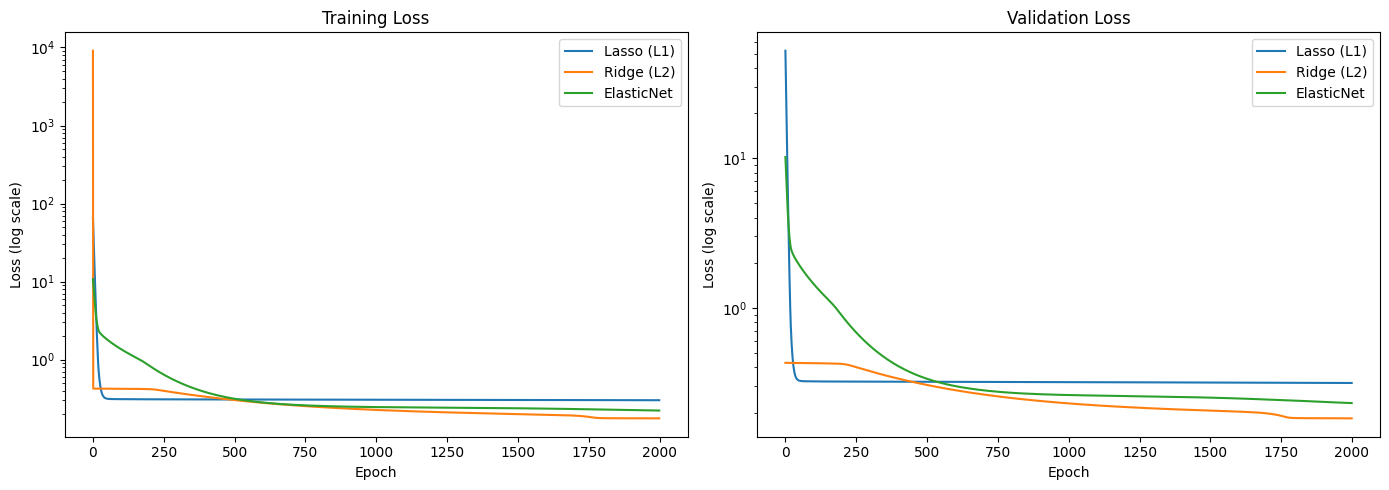

In [26]:
# Overlay all models on one plot
fig, (ax_train, ax_val) = plt.subplots(1, 2, figsize=(14, 5))

for name, model in models.items():
    ax_train.plot(model.train_losses, label=name)
    ax_val.plot(model.val_losses, label=name)

ax_train.set_title("Training Loss")
ax_train.set_xlabel("Epoch")
ax_train.set_ylabel("Loss (log scale)")
ax_train.set_yscale("log")
ax_train.legend()
ax_train.grid(False)

ax_val.set_title("Validation Loss")
ax_val.set_xlabel("Epoch")
ax_val.set_ylabel("Loss (log scale)")
ax_val.set_yscale("log")
ax_val.legend()
ax_val.grid(False)

plt.tight_layout()
plt.show()

### Model Evaluation
* Evaluate the trained model using the testing dataset
* Provide visualizations comparing actual values with the predicted regression outputs
* Performance Metrics
  * Mean Squared Error (MSE)
  * Mean Absolute Error (MAE)
  * Root Mean Squared Error (RMSE)
  * R² Score
  * Adjusted R² Score

In [27]:
def compute_metrics(y_true, y_pred, n_features):
    mse = np.mean((y_true - y_pred) ** 2)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(mse)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - ss_res / ss_tot
    n = len(y_true)
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)
    return {"MSE": mse, "MAE": mae, "RMSE": rmse, "R²": r2, "Adjusted R²": adjusted_r2}

n_features = X_test.shape[1]
results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    results[name] = compute_metrics(y_test, y_pred, n_features)

metrics_df = pd.DataFrame(results).T
metrics_df

,MSE,MAE,RMSE,R²,Adjusted R²
Lasso (L1),0.078926,0.224503,0.280938,-1.250350,-1.403783
Ridge (L2),0.084724,0.234063,0.291074,-1.415663,-1.580367
ElasticNet,0.045778,0.163994,0.213959,-0.305237,-0.394231


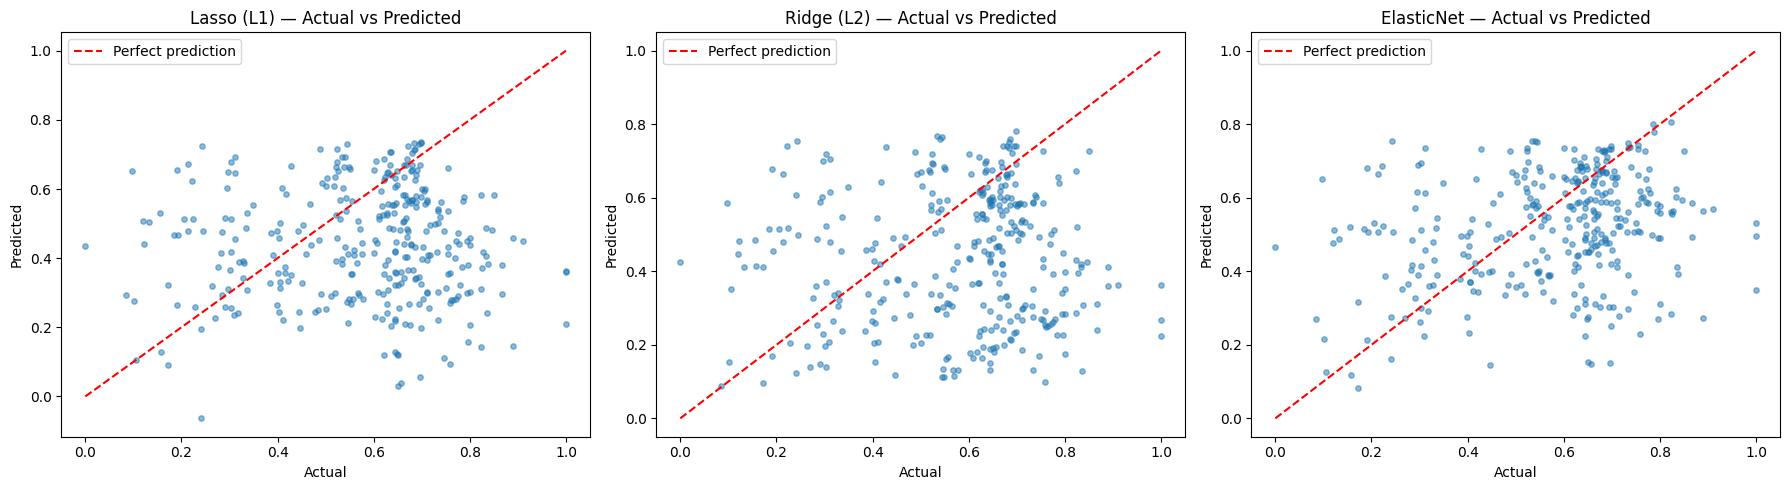

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test).flatten()
    y_actual = y_test.flatten()

    ax.scatter(y_actual, y_pred, alpha=0.5, s=15)
    ax.plot([0, 1], [0, 1], "r--", label="Perfect prediction")
    ax.set_title(f"{name} — Actual vs Predicted")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    ax.legend()
    ax.grid(False)

plt.tight_layout()
plt.show()

### Results Analysis

With $r^2 < 0$ for all regularization techniques, we can say this model is basically useless, since predicting the mean would perform better than our model.

### Additional Experiments
* 10000 epochs
* More advanced arhitecture
* Different optimization techniques